## Models
### Split data into training, validation and testing


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.neural_network import MLPClassifier
from sklearn import set_config
from sklearn.utils import shuffle

In [2]:
df = pd.read_csv('data/Preprossing_data.csv')

We shuffle data

In [3]:
df_shuffle = shuffle(df, random_state=4)
df_shuffle.head(5)

,date,time,temperature,dew_point,humidity,wind,wind_speed,wind_gust,pressure,precip.,condition
573,2021-07-12,10:30 PM,81,77,89,VAR,3,0,29.79,0.0,Others
1875,2021-08-09,5:00 AM,82,79,89,SW,9,0,29.73,0.0,Others
2965,2021-08-31,11:00 PM,79,77,94,CALM,0,0,29.79,0.0,Others
2791,2021-08-28,8:00 AM,81,77,89,VAR,1,0,29.73,0.0,Others
2056,2021-08-12,11:30 PM,82,77,84,VAR,2,0,29.82,0.0,Others


Separate `condition` from data

In [4]:
y_sr = df_shuffle['condition']
X_df = df_shuffle.drop(columns='condition')

We split data into training and testing set with $80\%$, $20\%$ respectively

In [5]:
X_df, test_X_df, y_sr, test_y_sr = train_test_split(X_df, y_sr, test_size=0.2, random_state=0)

In [6]:
X_df.shape

(2523, 10)

In [7]:
y_sr.shape

(2523,)

In [8]:
test_X_df.shape

(631, 10)

In [9]:
test_y_sr.shape

(631,)

Let check the distribution of two set

In [10]:
y_sr.value_counts()

Others    2259
Rain       264
Name: condition, dtype: int64

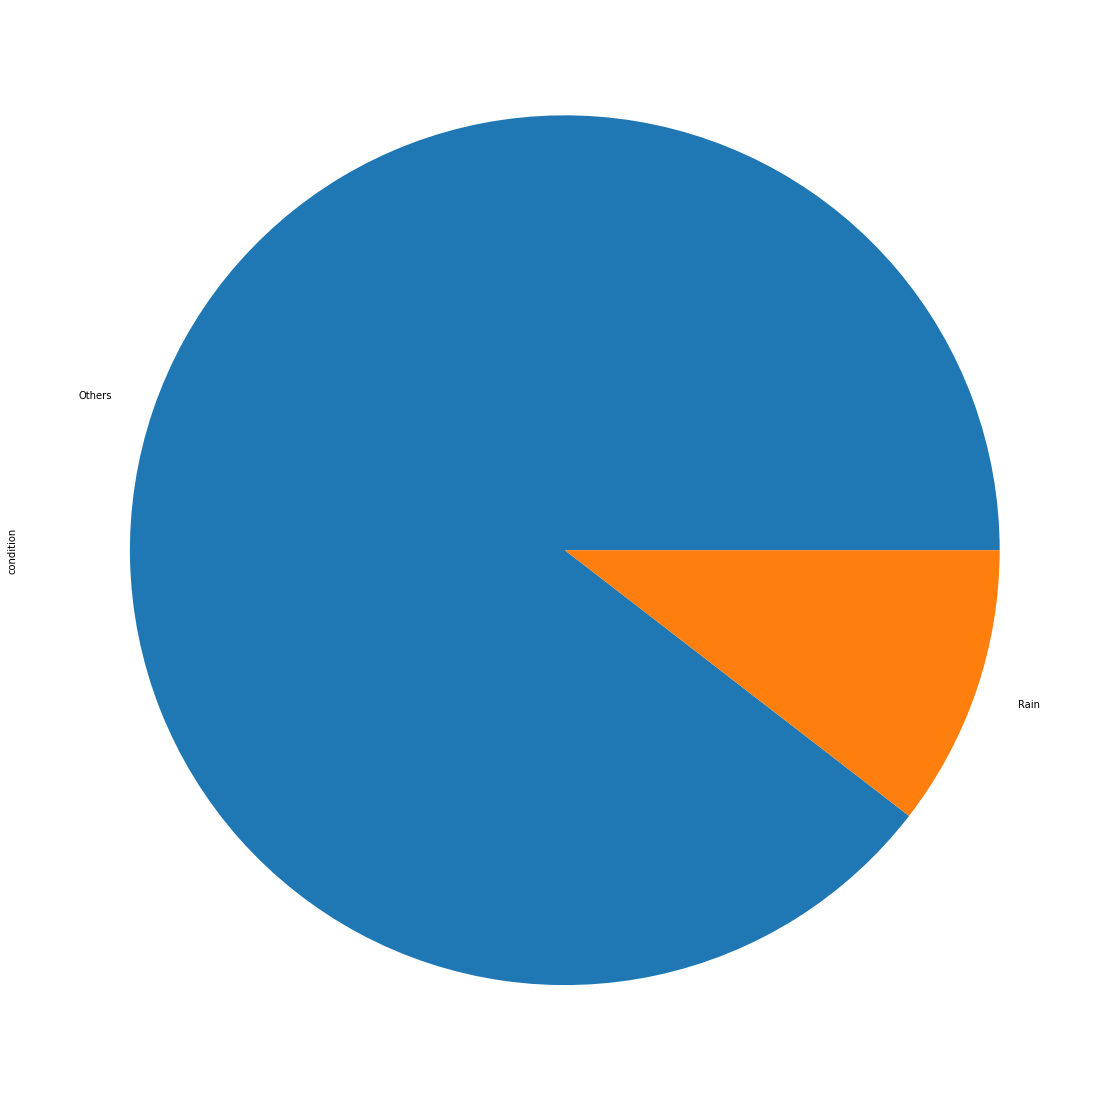

In [11]:
y_sr.value_counts().plot.pie(figsize=(20, 20))
plt.show()

In [12]:
test_y_sr.value_counts()

Others    572
Rain       59
Name: condition, dtype: int64

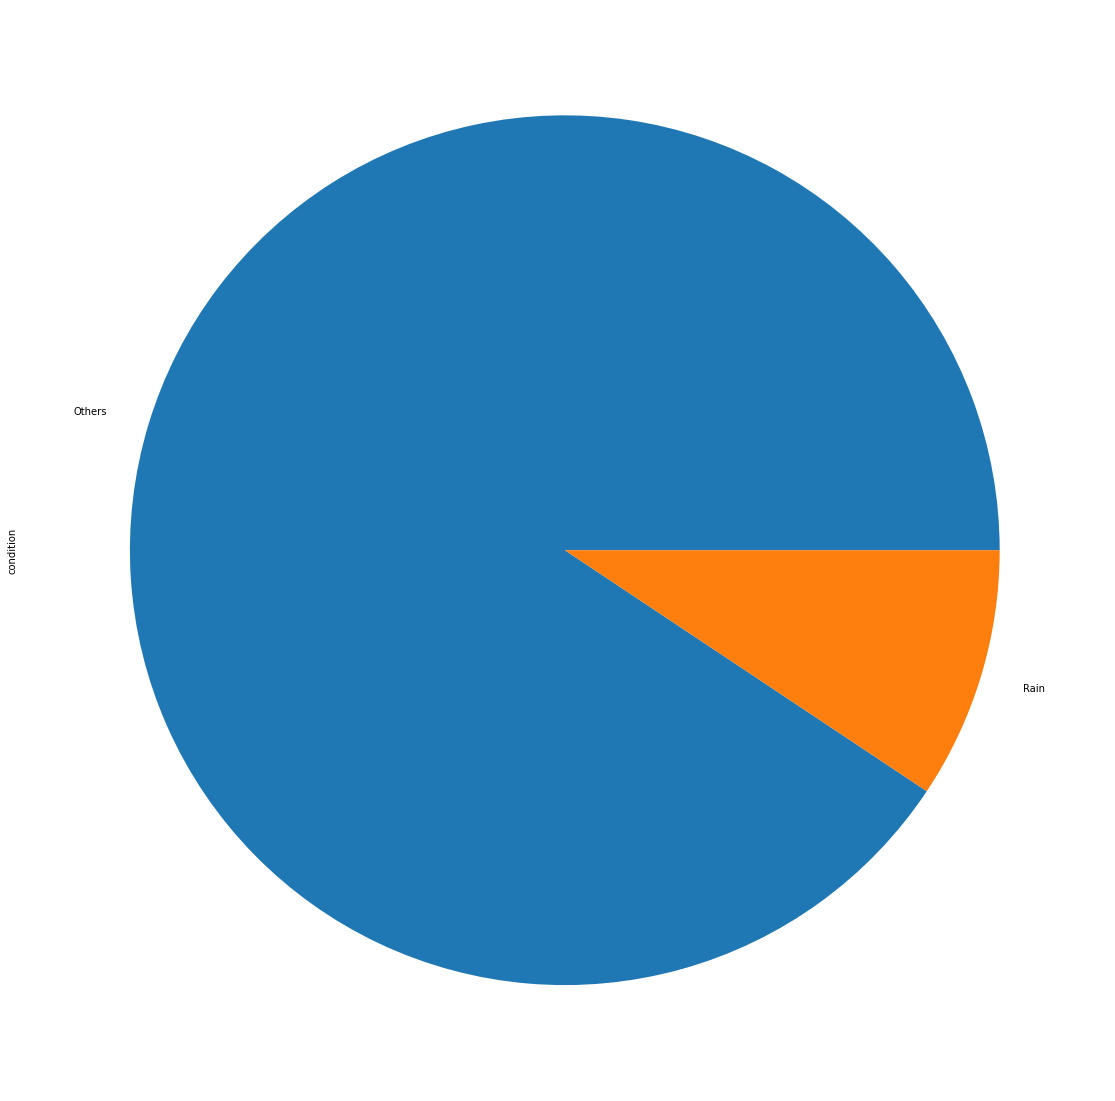

In [13]:
test_y_sr.value_counts().plot.pie(figsize=(20, 20))
plt.show()

The distribution of two set is approximate  
Next, we split training data into training and validation set

In [14]:
train_X_df, val_X_df, train_y_sr, val_y_sr = train_test_split(X_df, y_sr, test_size=0.25, random_state=0)

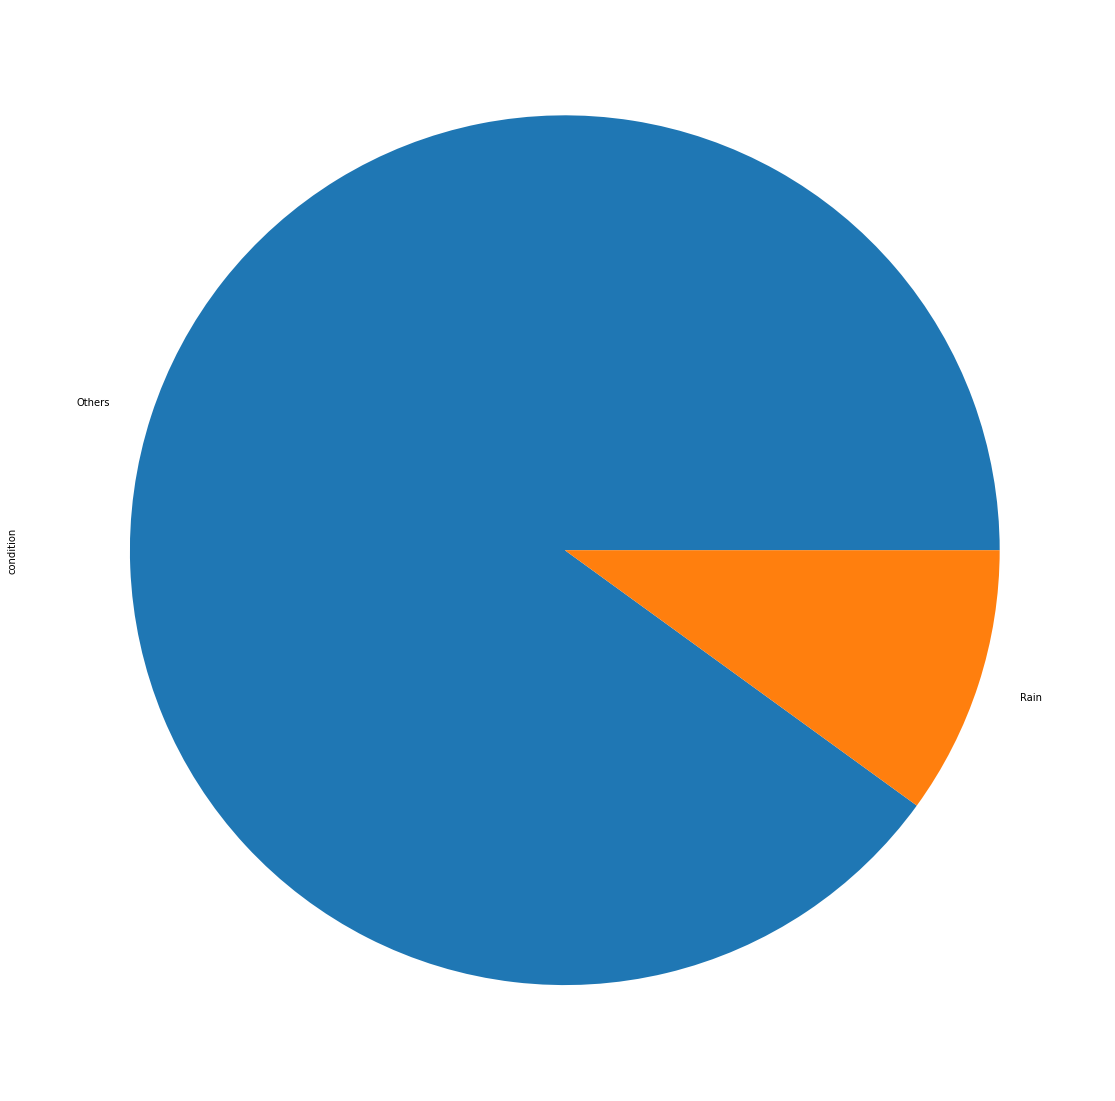

In [15]:
train_y_sr.value_counts().plot.pie(figsize=(20, 20))
plt.show()

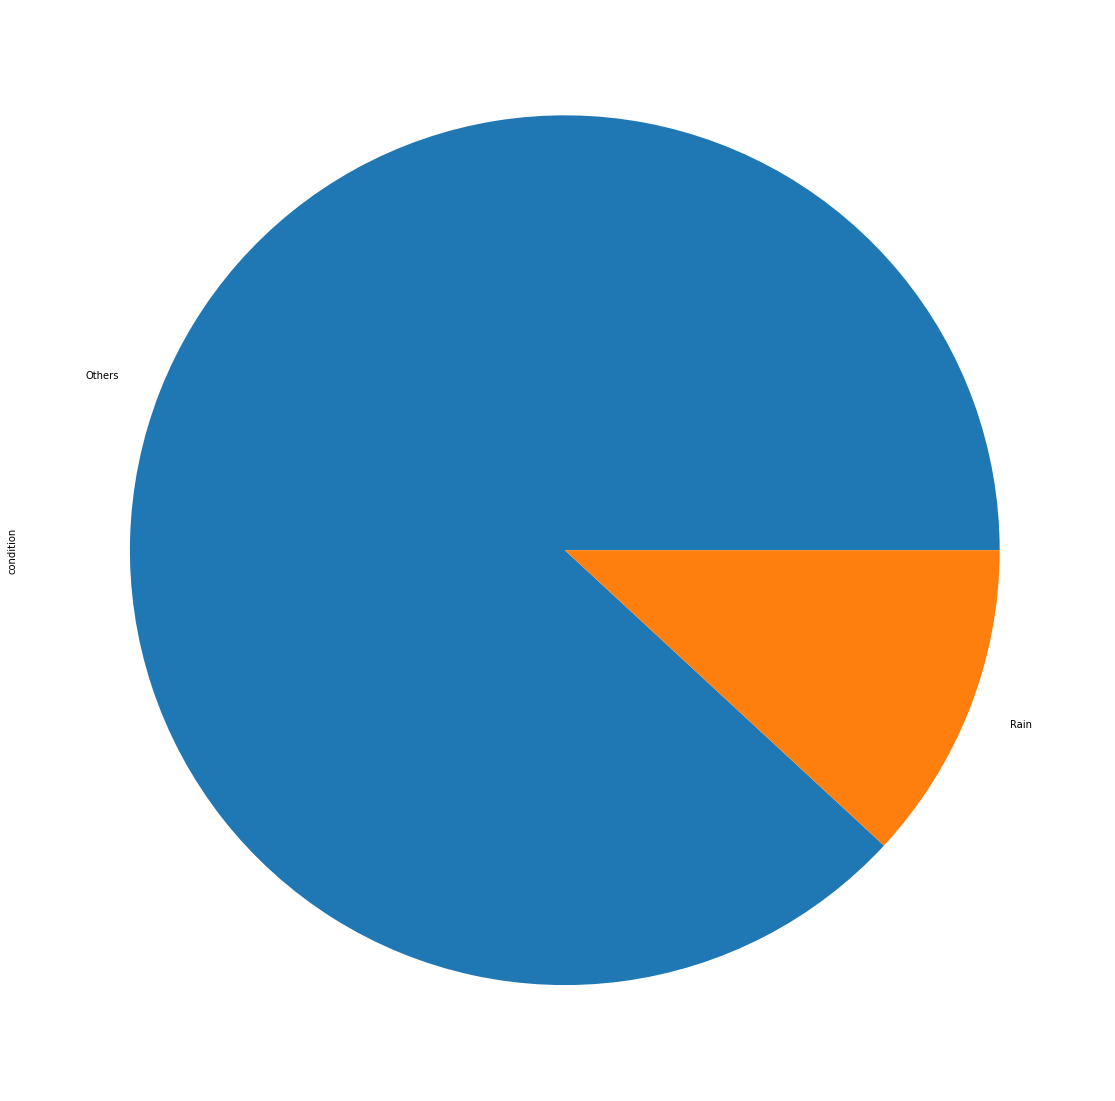

In [16]:
val_y_sr.value_counts().plot.pie(figsize=(20, 20))
plt.show()

Save training, validation, testing data

In [17]:
pd.concat([train_X_df, train_y_sr], axis=1).to_csv('data/training.csv', index=False)
pd.concat([val_X_df, val_y_sr], axis=1).to_csv('data/validation.csv', index=False)
pd.concat([test_X_df, test_y_sr], axis=1).to_csv('data/testing.csv', index=False)

## Preprocess data
After spliting data, we can free to preprocess data. Accroding to analysis in exploring data. There are what we will do:
* Remove `precip.`, `wind_gust` columns because it does not supply any useful information.
* Remove `date` column. The month can effect on weather, but the data we have only 3 months (July, August, September), therfore with new data, which occure in another months, model can be confused. In addition, we want to make model learning online, it means the data and model will be updated frequently, so that we think `date` column is not useful.
* With two unorder categorical columns `time` and `wind`, we use one hot encoding, in addition, because some values in wind appear very few, so that, we use a hyperparameter to keep the most frequent values.

In [18]:
class Preprocess(BaseEstimator, TransformerMixin):
    def __init__(self, num_top_wind=1):
        self.num_top_wind = num_top_wind
    def fit(self, X_df, y=None):
        wind_col = X_df.wind
        self.wind_counts_ = wind_col.value_counts()
        wind = list(self.wind_counts_.index)
        self.top_wind_ = wind[:max(1, min(self.num_top_wind, len(wind)))]
        return self
    def transform(self, X_df, y=None):
        temp_df = X_df.copy(deep = True)
        wind_col = temp_df.wind.str.extract(r'([A-Z]+)',expand = False)
        wind_col[~wind_col.isin(self.top_wind_)] = 'Others'
        temp_df['day_night'] =  temp_df.time.str.extract(r'([A-Z]+)')
        temp = pd.DataFrame(temp_df.time.str.split().tolist(),columns = ['t','dn'])
        temp_df['time'] = list(temp['t'])
        temp_df.drop(['precip.','date','wind_gust'], axis=1, inplace=True)
        return temp_df

Test `Preprocess` class

In [19]:
col_preprocess = Preprocess(num_top_wind=4)

In [20]:
fewer_cols_train_X_df = col_preprocess.fit_transform(train_X_df)

In [21]:
fewer_cols_train_X_df.head(5)

,time,temperature,dew_point,humidity,wind,wind_speed,pressure,day_night
3066,2:30,79,75,89,VAR,2,29.73,AM
1208,4:30,79,77,94,SW,5,29.70,AM
310,11:00,90,77,66,SW,12,29.70,AM
2134,2:30,91,77,63,WSW,9,29.67,PM
2972,2:30,79,77,94,VAR,1,29.76,AM


We will continue to preprocess following these steps:

- Numerical columns, we will fill in missing values with mean value
- Unorder categorical columns: `time` and `wind`: 
    - Convert to numerical using one-hot encoding method.
- Normalize data.

We will create a pipeline that executes these steps and also include the `Preprocess` class above.

In [22]:
num_cols = ['temperature','dew_point','humidity','wind_speed','pressure']
cate_cols = ['time','wind','day_night']

preprocess_pipeline = make_pipeline(Preprocess(num_top_wind=4),
                                    make_column_transformer(
                                        (SimpleImputer(missing_values = np.nan, strategy='mean'),num_cols),
                                        (OneHotEncoder(categories='auto', handle_unknown='ignore'), cate_cols)),
                                   StandardScaler(with_mean=False))

Test pipeline

In [23]:
preprocessed_train_X = preprocess_pipeline.fit_transform(train_X_df)

In [24]:
preprocessed_train_X.shape

(1892, 49)